#### Analysis using cross validation of a combined dataset of white and red wines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from math import log

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support, matthews_corrcoef,
                             roc_curve, accuracy_score, r2_score, classification_report, roc_auc_score, 
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set_palette("Accent")
sns.set_style("white")
#sns.despine()

plt_canvas_default = plt.rcParams['figure.figsize'] # save default canvas size

Data source: [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

In [3]:
redwine = pd.read_csv("./winequality-red.csv", sep = ';')
redwine = redwine.assign(color = "red")
redwine.shape

(1599, 13)

In [4]:
whitewine = pd.read_csv("./winequality-white.csv", sep = ';')
whitewine = whitewine.assign(color = "white")
whitewine.shape

(4898, 13)

Append the two datasets together. Create a binary rating variable from quality which is coded as 'good' for quality >= 7 and 'bad' otherwise.

In [5]:
wine = pd.concat([redwine, whitewine])
wine = wine.assign(rating = np.where(wine.quality >= 7, "good", "bad"))
wine.shape

(6497, 14)

In [6]:
pd.crosstab(wine.rating, wine.quality, margins=True)

quality,3,4,5,6,7,8,9,All
rating,,,,,,,,
bad,30,216,2138,2836,0,0,0,5220
good,0,0,0,0,1079,193,5,1277
All,30,216,2138,2836,1079,193,5,6497


In [7]:
# clean up column names
wine.columns = ['_'.join(col.split()) for col in wine.columns]
wine.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color', 'rating'],
      dtype='object')

In [8]:
wine.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
rating                   object
dtype: object

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(wine.iloc[:,:-1], wine.iloc[:,-1], test_size = 0.2, random_state = 0)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((5197, 13), (1300, 13), (5197,), (1300,))

In [10]:
xtrain.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.211112,0.340331,0.318917,5.402030,0.056147,30.570906,115.927266,0.994687,3.218037,0.531995,10.485645,5.817972
std,1.287543,0.165619,0.145061,4.664513,0.035135,17.966702,56.803135,0.002927,0.160284,0.149929,1.185198,0.871210
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992400,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996950,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,31.600000,0.611000,289.000000,440.000000,1.010300,4.010000,2.000000,14.900000,9.000000


Many of the variables appear to have extreme values. We can examine boxplots to identify them visually.

In [11]:
def plot_features(feature):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
    sns.boxplot(x=feature, ax=ax1)
    sns.kdeplot(feature, ax=ax2)

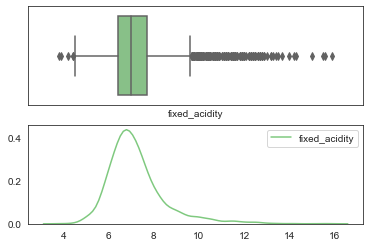

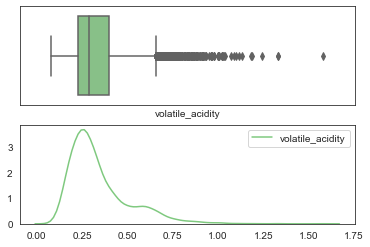

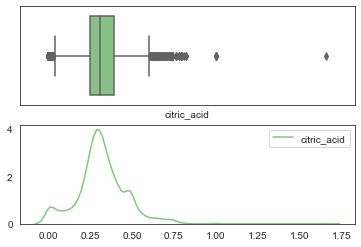

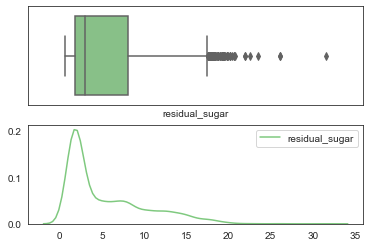

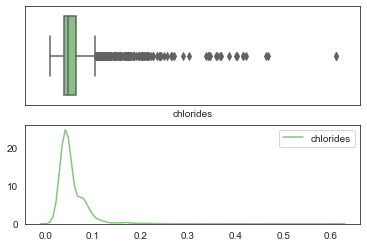

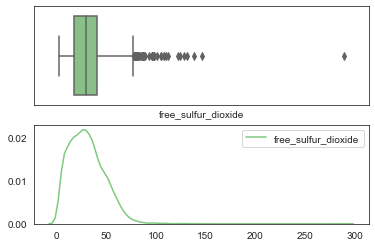

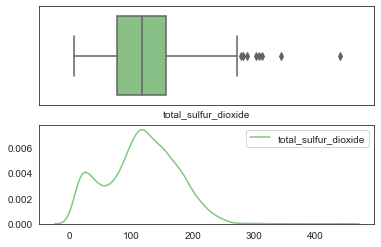

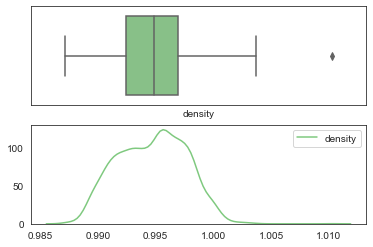

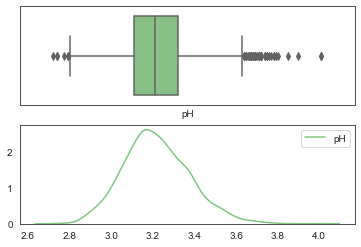

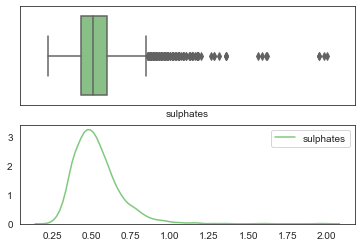

In [12]:
features = xtrain.columns.values.tolist()
for f in features[:-3]:
    plot_features(xtrain[f])

Except for alcohol, density and ph, the plots show a right skew in the data quite clearly . A log transformation of volatile acidity and fixed acidity makes the data more normal. Other variables have some extreme values - citric acid and total sulfur dioxide, for example. We retain them, for now.

In [13]:
# log transformation of acidity variables
xtrain["fixed_acidity"] = xtrain.fixed_acidity.apply(lambda x: log(x))
xtrain["volatile_acidity"] = xtrain.volatile_acidity.apply(lambda x: log(x))

xtest["fixed_acidity"] = xtest.fixed_acidity.apply(lambda x: log(x))
xtest["volatile_acidity"] = xtest.volatile_acidity.apply(lambda x: log(x))

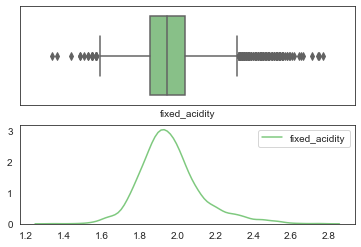

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
sns.boxplot(x=xtrain.fixed_acidity, ax=ax1)
sns.kdeplot(xtrain.fixed_acidity, ax=ax2)

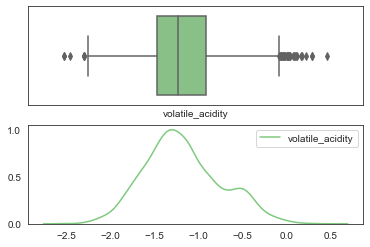

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
sns.boxplot(x=xtrain.volatile_acidity, ax=ax1)
sns.kdeplot(xtrain.volatile_acidity, ax=ax2)

What about wine quality?

In [16]:
ytrain.value_counts()/ytrain.value_counts().sum()

bad     0.802963
good    0.197037
Name: rating, dtype: float64

Only about 20 percent of the wines are rated as good

We can look at information classified by color of wine.

In [17]:
xtrain.color.value_counts()/xtrain.color.value_counts().sum()

white    0.752165
red      0.247835
Name: color, dtype: float64

In [18]:
pd.crosstab(xtrain.color, xtrain.quality, margins=True)

quality,3,4,5,6,7,8,9,All
color,,,,,,,,
red,9,40,557,493,173,16,0,1288
white,14,128,1168,1764,695,136,4,3909
All,23,168,1725,2257,868,152,4,5197


In [19]:
pd.crosstab(xtrain.color, ytrain, margins=True, normalize='all')

rating,bad,good,All
color,,,
red,0.211468,0.036367,0.247835
white,0.591495,0.160670,0.752165
All,0.802963,0.197037,1.000000


We can see that about 75% of the data is comprised of white wines. Most wines are rated 5, 6, or 7 and no red wines are rated 9 - the highest rating. Only four white wines have the highest rating. The joint distribution shows that about 16% of the wines are white and rated good.

We can look at the correlation table for the features.

In [20]:
corr = xtrain.corr()[(xtrain.corr() > 0.25) | (xtrain.corr() < -0.25)]
corr

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,NaN,0.310885,NaN,0.296102,-0.270569,-0.308047,0.470897,-0.279308,0.286530,NaN,NaN
volatile_acidity,NaN,1.000000,-0.339389,NaN,0.361947,-0.335573,-0.376481,0.267283,NaN,NaN,NaN,-0.256634
citric_acid,0.310885,-0.339389,1.000000,NaN,NaN,NaN,NaN,NaN,-0.342338,NaN,NaN,NaN
residual_sugar,NaN,NaN,NaN,1.000000,NaN,0.410065,0.498982,0.540720,-0.271736,NaN,-0.374520,NaN
chlorides,0.296102,0.361947,NaN,NaN,1.000000,NaN,-0.273946,0.367768,NaN,0.385715,-0.257137,NaN
free_sulfur_dioxide,-0.270569,-0.335573,NaN,0.410065,NaN,1.000000,0.722476,NaN,NaN,NaN,NaN,NaN
total_sulfur_dioxide,-0.308047,-0.376481,NaN,0.498982,-0.273946,0.722476,1.000000,NaN,NaN,-0.275214,-0.272537,NaN
density,0.470897,0.267283,NaN,0.540720,0.367768,NaN,NaN,1.000000,NaN,0.260673,-0.702969,-0.310885
pH,-0.279308,NaN,-0.342338,-0.271736,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
sulphates,0.286530,NaN,NaN,NaN,0.385715,NaN,-0.275214,0.260673,NaN,1.000000,NaN,NaN


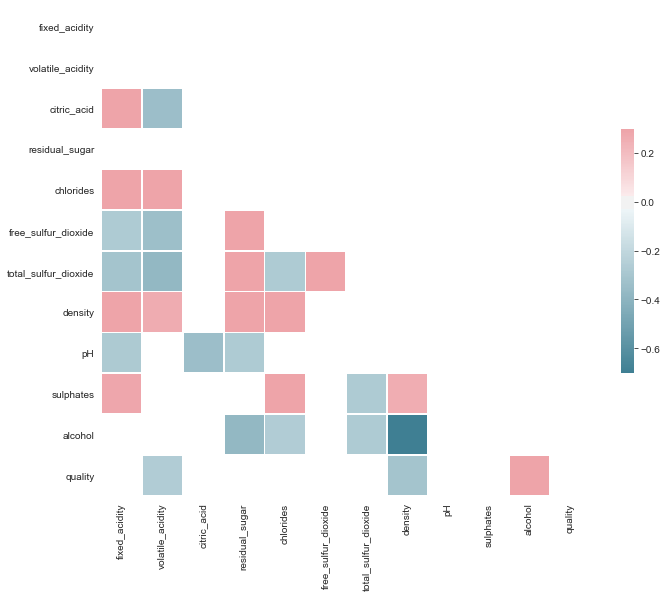

In [21]:
# visualize the table
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Only correlations above 0.25 or below -0.25 are shown in the table and the corresponding plot. Quality appears to be somewhat correlated with volatile acidity, density and alcohol. The correlations between total sulphur dioxide and free sulphur dioxide; and density and alcohol are above 0.7. Further, density is correlated with most other variables.

If we regress density on all predictors we get a R-square of 94% (not shown). We drop the variable from the analysis to avoid problems with collinearity. 'color' and 'quality' are also dropped.

In [22]:
xtrain.drop(columns = ['density'], inplace = True);
xtest.drop(columns = ['density'], inplace = True);

xtrain.drop(columns = ['color'], inplace = True);
xtest.drop(columns = ['color'], inplace = True);

xtrain.drop(columns = ['quality'], inplace = True);
xtest.drop(columns = ['quality'], inplace = True);

We can look plots of the predictors against the binary response 'rating'. 

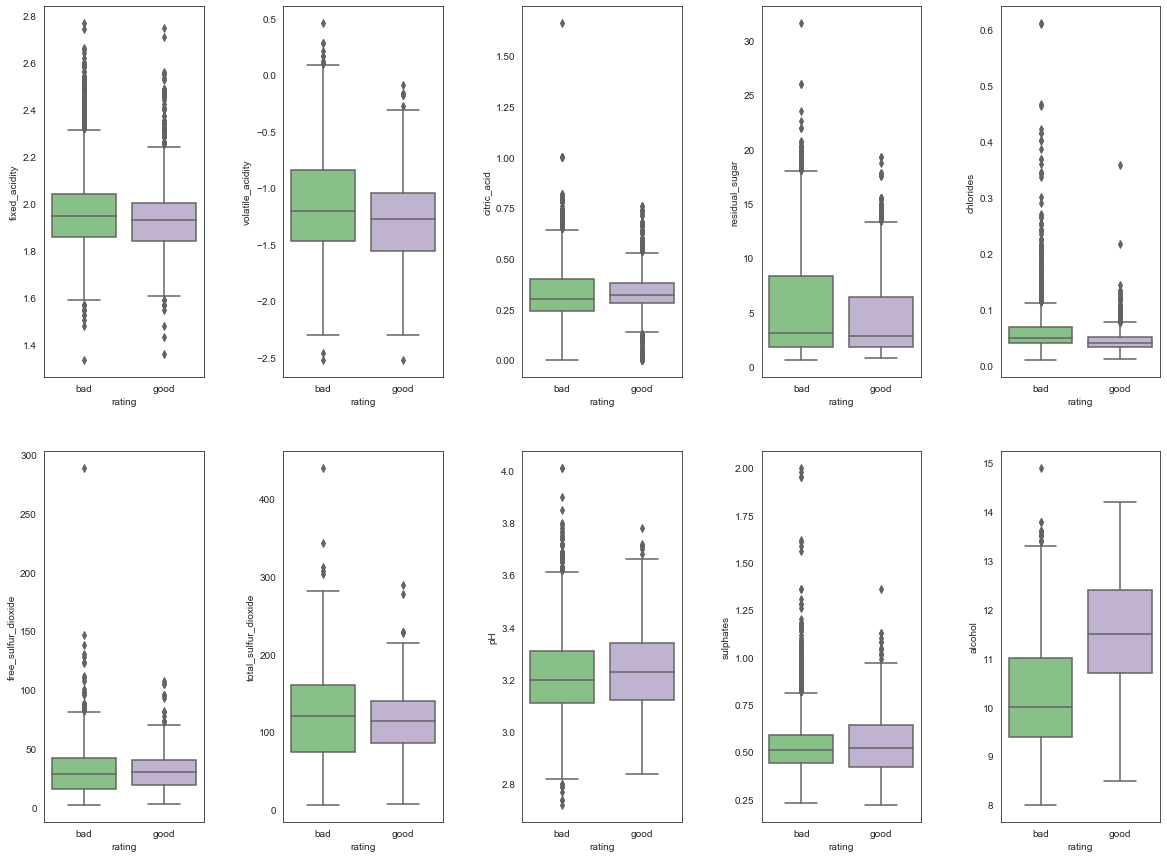

In [23]:
plt.rcParams['figure.figsize'] = [20, 15]
features = xtrain.columns.values.tolist()        

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.5)

for i, feature in enumerate(features):
    ax = fig.add_subplot(2, 5, i+1)
    sns.boxplot(x=ytrain, y=xtrain[feature], ax=ax)
    
plt.rcParams['figure.figsize'] = plt_canvas_default #reset canvas to default

Alcohol appears to discriminate the most between 'bad' and 'good' while volatile acidity shows a slight difference. Some of the others may be affected by the presence of extreme values.

Before starting our analysis, we standardize the predictors.

In [24]:
stdsc = StandardScaler()
xtrain_std = stdsc.fit_transform(xtrain)
xtest_std = stdsc.transform(xtest)

ytrain = ytrain.values
ytest = ytest.values

#### Baseline model
These are the errors one would get if we classified based on majority class. Any model one builds should perform better than baseline.

In [25]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)

clf.fit(xtrain_std, ytrain)
print(f"Error from baseline classifier predicting most frequent label in training set = {round(1 - clf.score(xtrain_std, ytrain), ndigits = 4)}")

Error from baseline classifier predicting most frequent label in training set = 0.197


#### Logistic grid search with cross validation

The logistic grid search with cross validation fits several logisitic models with different values for the tuning parameter C (= 1/alpha) for both l1 (lasso) and l2 (ridge) penalties; it averages each combination over the set number of folds and reports the one with the minimum average error. A high C (low alpha) is equivalent to a logistic model with no regularization penalty while a low C is a null model.

Create a parameter grid: there are two penalties and seven values of C which will give us 14 models. The cv parameter controls the number of folds in the cross validation; here it is set to 10.

In [26]:
penalty = ['l1', 'l2']
alphas = np.logspace(-4, -0.5, 30)
C = 1/alphas
params = dict(C = C, penalty = penalty)

In [27]:
nfolds = 10

lr_mod = LogisticRegression(solver = "liblinear", max_iter = 1000, random_state = 0)
clf = GridSearchCV(estimator = lr_mod, param_grid = params, cv = nfolds, verbose = 0)
clf.fit(xtrain_std, ytrain);

In [28]:
print(f"parameter settings that gave the best result: {clf.best_params_}")
print(f"mean cross validated score (accuracy) = {clf.best_score_}")

parameter settings that gave the best result: {'C': 7.278953843983146, 'penalty': 'l1'}
mean cross validated score (accuracy) = 0.8177794881662498


The recommended model is one with l1 penalty and C = 7.279 (alpha = 0.137). The high C indicates that the model is not very different from one without regularization as shown below. Accuracy of the model is only slightly better than baseline.

In [29]:
# high C = no regularization
lr0 = LogisticRegression(solver = 'liblinear', penalty='l1', C=1e5, 
                         class_weight=None, random_state=0, max_iter=1000, verbose=0)
lr0.fit(xtrain_std, ytrain)
print(f"Accuracy from logistic without regularization = {lr0.score(xtrain_std, ytrain)}")

Accuracy from logistic without regularization = 0.817009813353858


We can look at a plot of the mean cross validated score returned for every value of alpha (1/C) for a logistic model with l1 penalty.

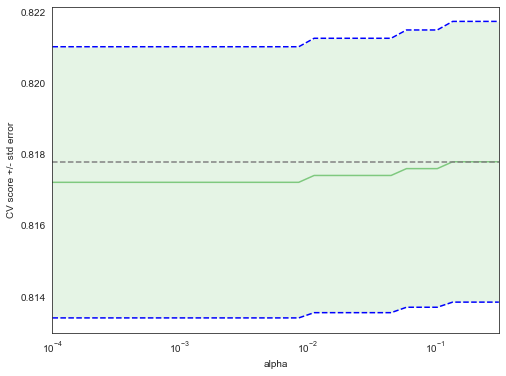

In [30]:
# https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py
# note that we are still using training data 
scores = clf.cv_results_['mean_test_score'][::2] #picks out l1 penalty results
scores_std = clf.cv_results_['std_test_score'][::2]
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(nfolds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha = 0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle = '--', color = '.5')
plt.xlim([alphas[0], alphas[-1]]);

In [31]:
lr_best_model = clf.best_estimator_

#### Support Vector Classifier

Next we try a Support Vector Classifier with cross validation. We set up the parameters and initialize the SVC object. C is the cost of misclassification: when C is small, there is high bias and low variance because the margin is wide and many observations may violate the margin. Gamma determines the influence of given training example with a large gamma leading to high bias and low variance.

In [32]:
C = [0.01, 0.1, 1.0, 5.0, 10.0]
gamma = [0.1, 0.5, 1, 2, 3]

grid_values = {'C': C, 'gamma': gamma}

In [33]:
nfolds = 10
svc = SVC(kernel = 'rbf', random_state = 0)
clf = GridSearchCV(svc, grid_values, cv = nfolds)
clf.fit(xtrain_std, ytrain);

In [34]:
print(f"parameter settings that gave the best result: {clf.best_params_}")
print(f"mean cross validated score (accuracy) = {clf.best_score_}")

parameter settings that gave the best result: {'C': 10.0, 'gamma': 2}
mean cross validated score (accuracy) = 0.8778141235328074


With the SVC we are doing better than in the case of the logistic with an accuracy of around 0.878. Cross validation selects a model with C = 10 and gamma = 2.

In [35]:
svc_best_model = clf.best_estimator_

#### KNN Classifier

In a KNN classifier, the parameter to be selected by cross validation is the number of neigbours. We pass a vector of odd values from 1 to 13.

In [36]:
k = np.arange(1, 15, 2)
parameters = {'n_neighbors': k}

In [37]:
knn_mod = KNeighborsClassifier()
clf = GridSearchCV(knn_mod, parameters, cv = 10)
clf.fit(xtrain_std, ytrain);

In [38]:
print(f"parameter settings that gave the best result: {clf.best_params_}")
print(f"mean cross validated score (accuracy) = {clf.best_score_}")

parameter settings that gave the best result: {'n_neighbors': 1}
mean cross validated score (accuracy) = 0.8535693669424668


The accuracy of the KNN classifier is less than that of the SVC but greater than the logistic. The optimal number of neighbors selected by cross validation is 1.

In [39]:
knn_best_model = clf.best_estimator_

#### Random Forests

In the Random Forests method, several trees are constucted by sampling repeatedly from the original data. Several parameters can be tuned including the number of trees, the depth of each tree, the minimum number of samples required to split a node, etc. We set up the parameters and initialize the model object.

In [40]:
samples_split = [2, 5, 10]
depth = [5, 10, 15, 20, 25, 30]
trees = [25, 50, 75, 100, 125, 150]

param_grid = {'n_estimators': trees, 'max_depth': depth, 'min_samples_split': samples_split}
param_grid

{'n_estimators': [25, 50, 75, 100, 125, 150],
 'max_depth': [5, 10, 15, 20, 25, 30],
 'min_samples_split': [2, 5, 10]}

In [41]:
rf_mod = RandomForestClassifier(random_state = 0)
clf = GridSearchCV(rf_mod, param_grid = param_grid, cv = 10)
clf.fit(xtrain_std, ytrain);

In [42]:
print(f"parameter settings that gave the best result: {clf.best_params_}")
print(f"mean cross validated score (accuracy) = {clf.best_score_}")

parameter settings that gave the best result: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}
mean cross validated score (accuracy) = 0.8853184529536271


With the random forests method, we get the highest accuracy we have seen so far. 

In [43]:
rf_best_model = clf.best_estimator_

We can look at which features are deemed important by the classifier.

In [44]:
importances = sorted(list(zip(list(xtrain.columns), clf.best_estimator_.feature_importances_)), key = lambda x: x[1], reverse = True)
importances

[('alcohol', 0.20497942148357887),
 ('chlorides', 0.1005365087018857),
 ('volatile_acidity', 0.09609932698936062),
 ('total_sulfur_dioxide', 0.09258030850552959),
 ('sulphates', 0.0901851819730662),
 ('residual_sugar', 0.08891738788739648),
 ('pH', 0.08608819332064854),
 ('free_sulfur_dioxide', 0.08344256345018078),
 ('citric_acid', 0.08129194030058126),
 ('fixed_acidity', 0.07587916738777205)]

Unsuprisingly, alcohol is the most important predictor.

#### Decision Tree Classifier

Although random forests method gives us a higher accuracy score, it is a time consuming procedure and it is not interpretable. We can try a simple decision tree classifier. We set up the parameters and initialize the method object.

In [45]:
param_grid = {
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

In [46]:
dtree = DecisionTreeClassifier(random_state = 0)
clf = GridSearchCV(dtree, param_grid = param_grid, cv = 10);
clf.fit(xtrain_std, ytrain);

In [47]:
print(f"parameter settings that gave the best result: {clf.best_params_}")
print(f"mean cross validated score (accuracy) = {clf.best_score_}")

parameter settings that gave the best result: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
mean cross validated score (accuracy) = 0.8345199153357706


It does worse than the random forests classifier but is still better than the logistic with l1 penalty.

In [48]:
dtree_best_model = clf.best_estimator_

As discussed previously, many of the variables have extreme values and it may be useful to refit the models without these values to check how they affect the models. It may also be worthwhile to explore interactions and non-linear effects. These are not attempted here.

#### Running best model on the test set
The random forest method is the one with the highest accuracy. We will now use it on the test set and evaluate its performance.

In [49]:
rf_best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [50]:
ytrue, ypred = ytest, rf_best_model.predict(xtest_std)

In [51]:
print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

         bad       0.90      0.96      0.93      1047
        good       0.77      0.55      0.65       253

    accuracy                           0.88      1300
   macro avg       0.84      0.76      0.79      1300
weighted avg       0.87      0.88      0.87      1300



The various metrics precision, recall and accuracy can also be calculated from the confusion matrix.

In [52]:
cm = confusion_matrix(ytrue, ypred)
cm

array([[1006,   41],
       [ 113,  140]])

In [53]:
tn, fp, fn, tp = cm.ravel() #flatten the matrix
tn, fp, fn, tp

(1006, 41, 113, 140)

In [54]:
print(f"precision = {round(tp/(tp + fp), ndigits = 3)}")
print(f"recall = {round(tp/(tp + fn), ndigits = 3)}")
print(f"accuracy = {round((tp + tn)/(tn + fp + fn + tp), ndigits = 3)}")

precision = 0.773
recall = 0.553
accuracy = 0.882


With the default threshold of 0.5, our model gives us an accuracy of 0.882 which is the same as the one we got from the 10-fold cross validation on the training data. We can look at two more measures for assessing the classifier.

The mcc ranges from -1 (completely incorrect) to +1 (completely correct).

In [55]:
mcc = matthews_corrcoef(ytrue, ypred)
print(f"Matthews correlation coefficient: {mcc:.3}")

Matthews correlation coefficient: 0.588


The ROC curve shows a plot of the true positive rate (recall) versus the false positive rate at various thresholds - the default is 0.5 but we can vary the thresholds.

In [56]:
probas_ = rf_best_model.predict_proba(xtest_std)
fpr, tpr, thresholds = roc_curve(ytrue, probas_[:, 1], pos_label='good')
roc_auc = roc_auc_score(ytrue, probas_[:, 1])
print(f"Area under ROC: {roc_auc:.3}")

Area under ROC: 0.924


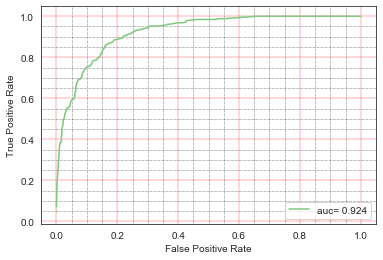

In [57]:
ax = sns.lineplot(fpr, tpr, label = f"auc= {round(roc_auc, ndigits = 3)}")
ax.set(xlabel = 'False Positive Rate', ylabel='True Positive Rate')

ax.grid()
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.3', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.legend(loc = 4)
plt.show()

The true positive rate is the recall but in the wine example, we may be more interested in increasing precision: in other words, we would like to reduce false positives which might reduce recall. Mistakenly classifying a bad wine as good may be considered a worse mistake than misclassifying a good wine. The reported precision is 0.773 which is based on the default threshold of 0.5; we can increase the threshold to get higher precision.  

We can look a confusion matrices at different thresholds - the default is 0.5.

In [58]:
ypred = np.where(probas_ >= 0.5, "good", "bad")

In [59]:
for threshold in [0.70, 0.75, 0.80, 0.85]:
    print(f"threshold = {threshold}")
    ypred = np.where(probas_ >= threshold, "good", "bad")
    cm = confusion_matrix(ytrue, ypred[:,1])
    print(f"confusion matrix:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel() #flatten the matrix
    
    print(f"precision = {round(tp/(tp + fp), ndigits = 3)}")
    print(f"recall = {round(tp/(tp + fn), ndigits = 3)}")
    
    mcc = matthews_corrcoef(ytrue, ypred[:,1])
    print(f"matthews corr coef: {mcc:.3}")

    print(f"accuracy = {round((tp + tn)/(tn + fp + fn + tp), ndigits = 3)}")
    
    print("-------------------------")

threshold = 0.7
confusion matrix:
[[1038    9]
 [ 167   86]]
precision = 0.905
recall = 0.34
matthews corr coef: 0.504
accuracy = 0.865
-------------------------
threshold = 0.75
confusion matrix:
[[1040    7]
 [ 181   72]]
precision = 0.911
recall = 0.285
matthews corr coef: 0.461
accuracy = 0.855
-------------------------
threshold = 0.8
confusion matrix:
[[1042    5]
 [ 197   56]]
precision = 0.918
recall = 0.221
matthews corr coef: 0.405
accuracy = 0.845
-------------------------
threshold = 0.85
confusion matrix:
[[1047    0]
 [ 215   38]]
precision = 1.0
recall = 0.15
matthews corr coef: 0.353
accuracy = 0.835
-------------------------


We can see that increasing the threshold improves precision (100% around a threshold of 0.83) but recall and accuracy suffer. We can look at a plot of precision versus recall which essentially visuallizes the previous calculation by varying thresholds.

In [60]:
precision, recall, thresholds = precision_recall_curve(ytrue, probas_[:, 1], pos_label='good')

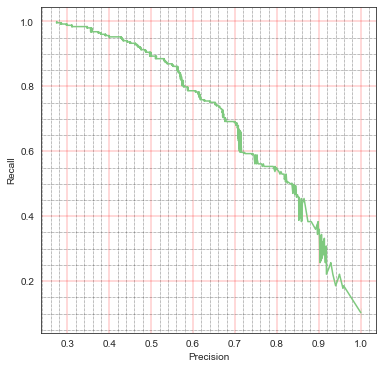

In [61]:
plt.rcParams['figure.figsize'] = [6, 6]
ax1 = sns.lineplot(precision, recall)
ax1.set(xlabel = 'Precision', ylabel='Recall')

ax1.grid()
ax1.set_axisbelow(True)
ax1.grid(linestyle='-', linewidth='0.5', color='red')
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.3', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.rcParams['figure.figsize'] = plt_canvas_default